2D Antiferromagnetic Model Example
========

This is an example of how ``ikron`` can be used to deal with a large, ``ndim > 1``, Hilbert space.
We'll define a simpler version of ``ham_heis_2D`` first:

In [1]:
import itertools
from operator import add
import numpy as np
from quimb import *

def ham_heis_2D(n, m, j=1.0, bz=0.0, cyclic=False,
                sparse=True):
    
    dims = [[2] * m] * n  # shape (n, m)
    
    # generate tuple of all site coordinates
    sites = tuple(itertools.product(range(n), range(m)))
    
    # generate neighbouring pairs of coordinates
    def gen_pairs():
        for i, j, in sites:
            above, right = (i + 1) % n, (j + 1) % m
            # ignore wraparound coordinates if not cyclic
            if cyclic or above != 0:
                yield ((i, j), (above, j))
            if cyclic or right != 0:
                yield ((i, j), (i, right))
    
    # generate all pairs of coordinates and directions
    pairs_ss = tuple(itertools.product(gen_pairs(), 'xyz'))
    
    # make XX, YY and ZZ interaction from pair_s
    #     e.g. arg ([(3, 4), (3, 5)], 'z')
    def interactions(pair_s):
        pair, s = pair_s
        Sxyz = spin_operator(s, sparse=True)
        return ikron(j * Sxyz, dims, inds=pair)
        
    # function to make Z field at ``site``
    def fields(site):
        Sz = spin_operator('z', sparse=True)
        return ikron(bz * Sz, dims, inds=[site])
                
    # combine all terms
    all_terms = itertools.chain(map(interactions, pairs_ss), 
                                map(fields, sites) if bz != 0.0 else ())
    H = sum(all_terms)

    # can improve speed of e.g. eigensolving if known to be real
    if isreal(H):
        H = H.real
    
    if not sparse:
        H = qarray(H.A)
        
    return H

Note that in general, for 1D or flat problems, ``dims`` is just the list of subsystem hilbert space sizes and indices are just specified as single integers. For 2D+ problems ``dims`` should be nested lists, or equivalently, an array of shape ``(n, m, ...)``, with coordinates specifying subsystems then given as ``inds=[(i1, j1, ...), (i2, j2, ...), ...]``.

We can now set up our parameters and generate the hamiltonian:

In [2]:
n, m = 4, 5
dims = [[2] * m] * n

for row in dims:
    print(row)

[2, 2, 2, 2, 2]
[2, 2, 2, 2, 2]
[2, 2, 2, 2, 2]
[2, 2, 2, 2, 2]


In [3]:
H = ham_heis_2D(n, m, cyclic=False)

Let's also break the symmetry, so that we get a nice alternating pattern, by adding a small field on the site ``(1, 2)``:

In [4]:
H = H + 0.2 * ikron(spin_operator('Z', sparse=True), dims, [(1, 2)])

Note that ``ikron`` automatically performs a sparse kronecker product when given a sparse operator(s).

Next we find its ground state and energy, which should be reasonably quick for 20 qubits
(we could also make use of symmetries here to project the hamiltonian first):

In [5]:
%time ge, gs = eigh(H, k=1)

CPU times: user 708 ms, sys: 1.04 s, total: 1.75 s
Wall time: 11.6 s


Giving us energy:

In [6]:
ge[0]

-11.66157392979066

Now let's compute the magnetization at each site.
First we construct the Z spin operators:

In [7]:
Sz = spin_operator('Z', stype='coo')
Sz_ij = [[ikron(Sz, dims, [(i, j)]) 
          for j in range(m)] 
         for i in range(n)]

Then we compute the expectation of each at each site:

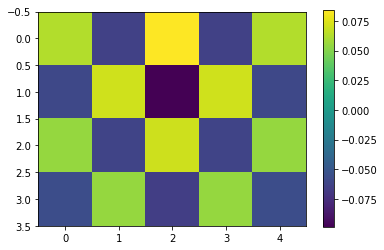

In [8]:
m_ij = [[expec(Sz_ij[i][j], gs) 
         for j in range(m)] 
        for i in range(n)]

%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(m_ij)
plt.colorbar()

Which looks pretty much as expected.

Alternatively to using global operators, we could also use ``partial_trace`` to look at the state of a few qubits. For example, let's find the correlations between the spin we added the small field to, and every other spin.

Find the reduced density matrices first:

In [9]:
target = (1, 2)

rho_ab_ij = [[partial_trace(gs, dims=dims, keep=[target, (i, j)])
              for j in range(m)]
             for i in range(n)]

Since one density matrix is just the spin itself, let's purify it when we come across it, meaning we'll find its total entanglement with it's environment:

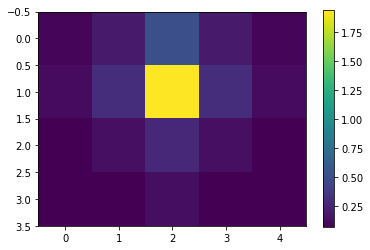

In [10]:
mi_ij = [[mutinf(rho_ab_ij[i][j] if (i, j) != target else 
                 purify(rho_ab_ij[i][j]))
          for j in range(m)]
         for i in range(n)]

plt.imshow(mi_ij)
plt.colorbar()

One could also compute: ``concurrence``, ``logneg``, ``quantum_discord``, ``correlation`` ...

For example we could set up the y-correlation function:

In [11]:
Sy = spin_operator('y')
z_corr = correlation(None, Sy, Sy, 0, 1, dims=[2, 2], precomp_func=True)

And compute the correlations:

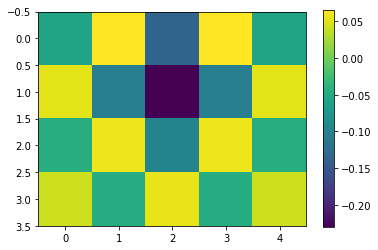

In [12]:
cy_ij = [[z_corr(rho_ab_ij[i][j] if (i, j) != target else 
                 purify(rho_ab_ij[i][j]))
          for j in range(m)]
         for i in range(n)]

plt.imshow(cy_ij)
plt.colorbar()